# Experimentation and Results

Our experiments are divided into three main parts:
1. Implementation of offensive and defensive formation detection for UGP high-frequency GPS tracking data.
2. Computation of player stationarity within detected attacking and defending phases.
3. Analysis on StatsBomb event data to validate formation detection in sparse data scenarios. 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.optimize import linear_sum_assignment 
import ruptures as rpt
import sys

try:
    import os
    os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.1"
    os.add_dll_directory(r"C:\Program Files\R\R-4.3.1\bin\x64")
    import rpy2.robjects as robjects
    from rpy2.robjects import numpy2ri
    from rpy2.robjects.packages import importr
    numpy2ri.activate()
    gSeg = importr("gSeg")
except ImportError:
    print("Error importing rpy2. Ensure R is installed if using gSeg.")

rng = np.random.default_rng(0)

import src.Preprocessing as prep
import src.FormCPD as FormCPD
import src.RoleCPD as RoleCPD

In [2]:
# Data
# We provide several UGP files in the 'data/ugp/' directory.
# Each file corresponds to a different match.
# The '17985.ugp' file is from the K-League (South Korea), provided by Fitogether.
# The 7 digit files are from the A-League (Australia), provided by SkillCorner.
# The 'Real_vs_Barcelona_Calma.ugp' file is provided by Last Row, as part of the Friends of Tracking initiative. Note that it only contains one play and not a full match.
fitogether = prep.FitogetherDiagnosis(data_path='data/ugp/1925299.ugp')
gps_data = fitogether.load_or_generate_data()

Loading data from data/ugp/1925299.ugp.
Format: Metric (Centered). No transformation needed.

--- [Fitogether] Orientation Check ---
Player X Medians Range: -15.41 to 23.57
Orientation is left to right. No changes made.


# 1. Offensive and Defensive Formation Change Point Detection (FormCPD)

We first define a helper function to stitch player trajectories into fixed slots, handling substitutions.

In [3]:
def get_stitched_tensor(df, n_slots=10):
    """
    Stitches disjoint player trajectories into 'n_slots' continuous tracks.
    This handles substitutions (e.g. Player A off, Player B on -> Slot 1).
    """
    # Identify temporal range for each player
    player_ranges = []
    for pid, group in df.groupby('player_id'):
        start = group['frame'].min()
        end = group['frame'].max()
        duration = len(group)
        player_ranges.append({
            'player_id': pid,
            'start': start,
            'end': end,
            'duration': duration,
            'data': group.set_index('frame')[['x', 'y']]
        })
    
    # Sort players by duration (longest playing time first) to identify core players
    player_ranges.sort(key=lambda x: x['duration'], reverse=True)
    
    # Assign players to slots
    # List of dicts: {'end_frame': int, 'data': series}
    slots = []
    
    for p in player_ranges:
        assigned = False
        # Try to fit into an existing slot (substitution)
        for s in slots:
            # Check if this player starts after the slot ends (plus a small buffer)
            if p['start'] > s['end_frame'] + 10: # 10 frames buffer
                s['parts'].append(p)
                s['end_frame'] = max(s['end_frame'], p['end'])
                assigned = True
                print(f"Stitched Player {p['player_id']} into Slot {s['id']}")
                break
        
        # If not assigned, create a new slot
        if not assigned:
            slots.append({
                'id': len(slots),
                'end_frame': p['end'],
                'parts': [p]
            })
            
    # Filter to top N slots
    if len(slots) > n_slots:
        print(f"Found {len(slots)} distinct tracks. Keeping top {n_slots} by duration.")
        for s in slots:
            s['total_duration'] = sum(p['duration'] for p in s['parts'])
        slots.sort(key=lambda x: x['total_duration'], reverse=True)
        slots = slots[:n_slots]
        
    # Construct the Tensor
    frames = sorted(df['frame'].unique())
    n_frames = len(frames)
    frame_map = {f: i for i, f in enumerate(frames)}
    
    X_tensor = np.full((n_frames, n_slots, 2), np.nan)
    
    for i, s in enumerate(slots):
        for part in s['parts']:
            indices = [frame_map[f] for f in part['data'].index if f in frame_map]
            X_tensor[indices, i, :] = part['data'].loc[list(part['data'].index)].values
            
    return X_tensor

In [4]:
# Stitching
print("Stitching trajectories to handle substitutions")
X_full = get_stitched_tensor(gps_data, n_slots=10)
# New shape should be (T x 10 x 2)
print(f"New Tensor Shape: {X_full.shape}.")

Stitching trajectories to handle substitutions
Stitched Player 560988 into Slot 19
Stitched Player 795533 into Slot 20
Stitched Player 966115 into Slot 21
Stitched Player 51722 into Slot 15
Stitched Player 795541 into Slot 16
Stitched Player 965698 into Slot 17
Stitched Player 809869 into Slot 14
Stitched Player 333110 into Slot 13
Stitched Player 966113 into Slot 12
Found 23 distinct tracks. Keeping top 10 by duration.
New Tensor Shape: (47942, 10, 2).


In [5]:
# Imputation
if np.isnan(X_full).any():
    print(f"Found {np.isnan(X_full).sum()} NaN values in trajectory data. Imputing...")
    for p in range(X_full.shape[1]):
        for dim in range(2):
            series = pd.Series(X_full[:, p, dim])
            series = series.interpolate(method='linear', limit_direction='both')
            series = series.fillna(method='bfill').fillna(method='ffill')
            X_full[:, p, dim] = series.values

    # Safety check for empty tracks
    if np.isnan(X_full).any():
        print("Warning: Replacing remaining NaNs with 0.")
        X_full = np.nan_to_num(X_full, nan=0.0)

In [6]:
# Phase Classification
# Calculate Team Centroid (average X position) per frame
team_centroid_x = np.mean(X_full[:, :, 0], axis=1)

# Define thresholds for attack and defense
ATTACK_THRESH = 5.0
DEFENSE_THRESH = -5.0

idx_attack = np.where(team_centroid_x > ATTACK_THRESH)[0]
idx_defense = np.where(team_centroid_x < DEFENSE_THRESH)[0]

print(f"Identified {len(idx_attack)} attacking frames and {len(idx_defense)} defensive frames.")

Identified 20952 attacking frames and 16981 defensive frames.


In [7]:
# EM-Hungarian Role Assignment
mu_global, roles_global = FormCPD.em_hungarian(X_full, n_iter=10)

EM-Hungarian: 100%|██████████| 10/10 [02:38<00:00, 15.86s/it]


In [11]:
# Helper function to plot formations
def plot_formation(ax, mu, title, color):
    # Safety check: if data has NaNs or Infs, skip plotting to prevent crash
    if np.isnan(mu).any() or np.isinf(mu).any():
        ax.text(0, 0, "Invalid Data (NaN/Inf)", ha='center', color='red')
        ax.axis('off')
        return

    try:
        tri = Delaunay(mu)
        ax.triplot(mu[:, 0], mu[:, 1], tri.simplices, color='gray', linestyle=':', alpha=0.5)
        ax.scatter(mu[:, 0], mu[:, 1], s=200, c=color, edgecolors='black', zorder=5)
        for i, (x, y) in enumerate(mu):
            ax.text(x, y, str(i), fontsize=12, ha='center', va='center', color='white', fontweight='bold')
    except Exception as e:
        ax.text(0, 0, "Plot Error", ha='center', color='red')
    
    # Pitch Layout
    pitch_length = 105
    pitch_width = 68
    ax.axvline(-pitch_length/2, color='k', lw=2)
    ax.axvline(pitch_length/2, color='k', lw=2)
    ax.axhline(-pitch_width/2, color='k', lw=2)
    ax.axhline(pitch_width/2, color='k', lw=2)
    ax.set_xlim(-(pitch_length/2 + 5), (pitch_length/2 + 5))
    ax.set_ylim(-(pitch_width/2 + 5), (pitch_width/2 + 5))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Length (m)")
    ax.set_ylabel("Width (m)")

In [15]:
# We also define a pure Python version of the formation change detection in case of R/gSeg issues.
def detect_formation_changes_python(adjacency_sequence, min_minutes=5, n_bkps=4):
    """
    Detects formation changes using the Kernel Change Point Detection (Python only).
    Replaces the unstable R/gSeg implementation.
    """
    # Flatten (T, 10, 10) matrices into (T, 100) vectors
    T_sub = adjacency_sequence.shape[0]
    data_flat = adjacency_sequence.reshape(T_sub, -1)
    
    # Calculate minimum segment size in frames (1Hz assumption)
    min_size = min_minutes * 60 
    
    # Use Binary Segmentation
    try:
        algo = rpt.Binseg(model="l2", min_size=min_size).fit(data_flat)
        change_points = algo.predict(n_bkps=n_bkps)
    except Exception as e:
        print(f"Warning: Segmentation failed - {e}.")
        change_points = [T_sub]

    # Format results like the original output
    bkps = sorted(list(set([0] + change_points + [T_sub])))
    
    # Create segments list [(start, end), (start, end)...]
    segments = []
    for i in range(len(bkps) - 1):
        segments.append((bkps[i], bkps[i+1]))
    internal_cps = [cp for cp in bkps if cp != 0 and cp != T_sub]
    
    return {
        'num_phases': len(segments),
        'change_points': internal_cps,
        'segments': segments
    }

In [17]:
sys.setrecursionlimit(100)

T = X_full.shape[0]

# Align positions based on roles
X_roles = np.zeros_like(X_full)
for t in range(T):
    current_roles = roles_global[t]
    player_indices = np.argsort(current_roles)
    X_roles[t] = X_full[t, player_indices]

# Build graphs
subsample_rate = 100 
X_sub = X_roles[::subsample_rate]
valid_frames = np.arange(0, T, subsample_rate)

A_sequence = []
for t in range(len(X_sub)):
    # Calculate adjacency matrix
    try:
        adj = FormCPD.delaunay_adjacency(X_sub[t])
        A_sequence.append(adj)
    except Exception as e:
        # Fallback
        A_sequence.append(np.zeros((10, 10)))

A_sequence = np.array(A_sequence)

# Detect Changes 
print("Running Detection")
try:
    results = FormCPD.detect_formation_changes(
        A_sequence, 
        fps=1,            
        alpha=0.01,       
        min_minutes=5,    
        min_dist=10.0     
    )
    print("Detection complete.")
    print(f"Detected {results['num_phases']} Phase{'s' if results['num_phases'] != 1 else ''}.")
except Exception as e:
    # We encountered a few errors during implementation
    print(f"Crash or error during detection: {e}")
    print("Using Python method instead.")
    results = detect_formation_changes_python(A_sequence, min_minutes=5, n_bkps=4)
    detected_frames = [valid_frames[cp] for cp in results['change_points'] if cp < len(valid_frames)]
    print(f"Detection Complete.")
    print(f"Detected {results['num_phases']} Phase{'s' if results['num_phases'] != 1 else ''}.")
    print(f"Change Points (approx Frame IDs): {detected_frames}")

Running Detection
Detection complete.
Detected 1 Phase.


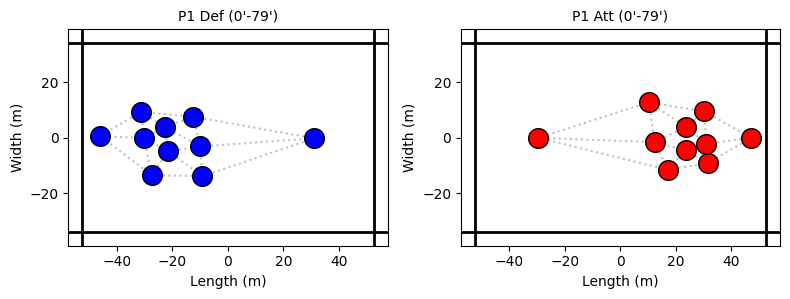

In [ ]:
# Visualization of Detected Phases
n_phases = results['num_phases']
segments = results['segments']

# We limit the number of phases to plot for clarity (and to prevent OOM crashes)
MAX_PHASES_TO_PLOT = 10
if n_phases > MAX_PHASES_TO_PLOT:
    print(f"Warning: Too many phases detected ({n_phases}). Plotting first {MAX_PHASES_TO_PLOT} only.")
    n_plot = MAX_PHASES_TO_PLOT
else:
    n_plot = n_phases

# Create boolean masks 
is_attack = np.zeros(T, dtype=bool)
if 'idx_attack' in locals(): is_attack[idx_attack] = True

is_defense = np.zeros(T, dtype=bool)
if 'idx_defense' in locals(): is_defense[idx_defense] = True

# Create Figure
fig, axes = plt.subplots(n_plot, 2, figsize=(8, 4 * n_plot))
if n_plot == 1: axes = axes[:, np.newaxis]

for i in range(n_plot):
    start_sub, end_sub = segments[i]
    f_start = valid_frames[start_sub]
    f_end = valid_frames[min(end_sub, len(valid_frames)-1)]
    
    phase_data = X_roles[f_start:f_end]
    mask_att = is_attack[f_start:f_end]
    mask_def = is_defense[f_start:f_end]
    
    # Defense
    if np.any(mask_def):
        mu_def = np.nanmean(phase_data[mask_def], axis=0)
        plot_formation(axes[0, i], mu_def, f"P{i+1} Def ({f_start//600}'-{f_end//600}')", 'blue')
    else:
        axes[0, i].text(0,0, "No Data", ha='center')
        axes[0, i].axis('off')
        
    # Attack
    if np.any(mask_att):
        mu_att = np.nanmean(phase_data[mask_att], axis=0)
        plot_formation(axes[1, i], mu_att, f"P{i+1} Att ({f_start//600}'-{f_end//600}')", 'red')
    else:
        axes[1, i].text(0,0, "No Data", ha='center')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
def calculate_player_stationarity(X_tensor, segments, attack_indices, defense_indices):
    """
    Calculates the spatial standard deviation (stationarity) of players
    for each formation phase, split by Attack and Defense.
    
    Lower Std Dev = Higher Stationarity (Fixed Position)
    Higher Std Dev = Lower Stationarity (Free Roaming)
    """
    stationarity_results = []

    for phase_id, (start, end) in enumerate(segments):
        # 1. Define time range for this phase
        phase_frames = np.arange(start, end)
        
        # 2. Intersect phase frames with Attack/Defense frames
        # We assume X_tensor indices align with the global frame indices
        phase_att_idx = np.intersect1d(phase_frames, attack_indices)
        phase_def_idx = np.intersect1d(phase_frames, defense_indices)
        
        # 3. Calculate metrics for Attack
        if len(phase_att_idx) > 10: # Minimum threshold to calculate stats
            # Get positions: (N_frames, N_players, 2)
            pos_att = X_tensor[phase_att_idx] 
            # Calculate Mean Center for each player
            means_att = np.nanmean(pos_att, axis=0)
            # Calculate Euclidean distance of every point to its mean
            dists_att = np.linalg.norm(pos_att - means_att, axis=2)
            # Stationarity Metric: Standard Deviation of distances (Spread)
            std_att = np.nanstd(dists_att, axis=0)
        else:
            std_att = np.zeros(X_tensor.shape[1])

        # 4. Calculate metrics for Defense
        if len(phase_def_idx) > 10:
            pos_def = X_tensor[phase_def_idx]
            means_def = np.nanmean(pos_def, axis=0)
            dists_def = np.linalg.norm(pos_def - means_def, axis=2)
            std_def = np.nanstd(dists_def, axis=0)
        else:
            std_def = np.zeros(X_tensor.shape[1])
            
        stationarity_results.append({
            'phase': phase_id,
            'attack_std': std_att,
            'defense_std': std_def
        })
        
    return stationarity_results

print("Stationarity function defined.")

Stationarity function defined.


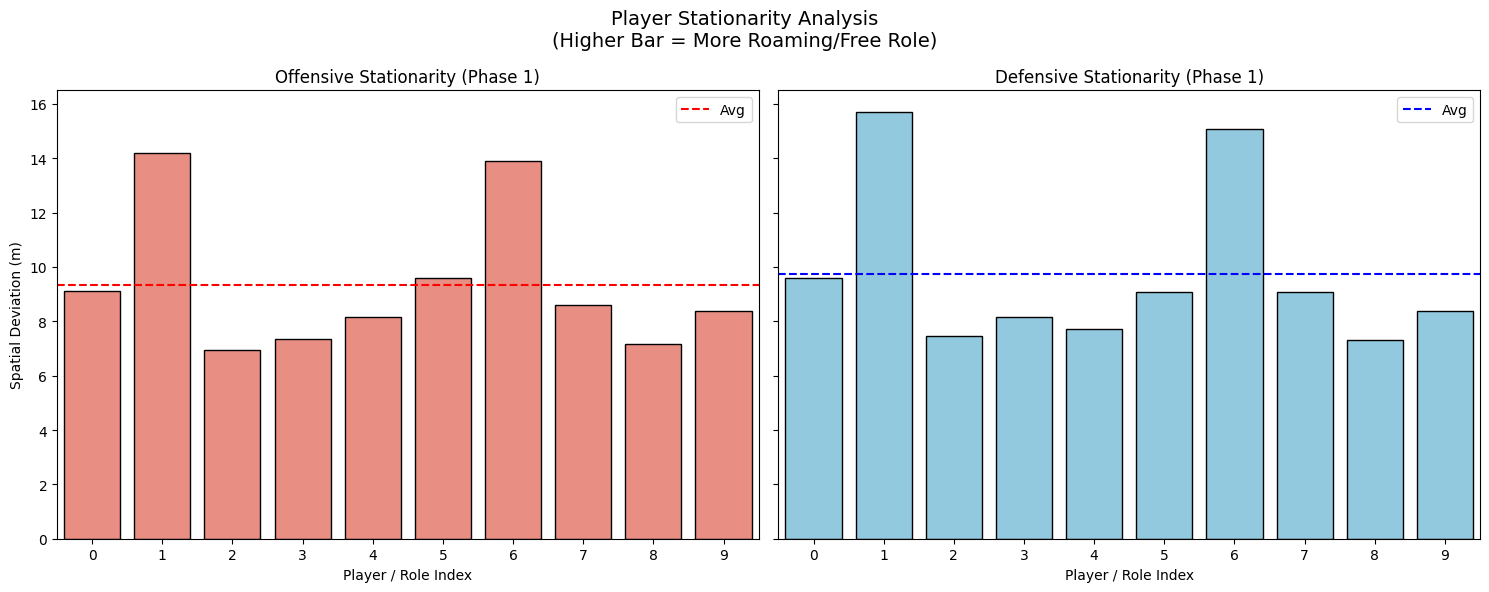

Interpretation:
- Low Deviation (< 5m): Highly Stationary (e.g., Center Backs)
- High Deviation (> 10m): High Roaming (e.g., Free Role Playmakers/Wingers)
Most active roamer in Attack: Player/Role 1 (14.20m deviation)


In [19]:
# 1. Setup Data needed
# We assume 'X_full' (Trajectory Tensor), 'results' (from FormCPD), 
# and 'idx_attack'/'idx_defense' are available from previous cells.

# Extract segments from detection results
# Note: Ensure start/end are mapped to X_full indices (if subsampled, scale back)
# Since we detected on subsampled data, we map back to full indices roughly:
det_segments_sub = results['segments']
det_segments_full = [(s*subsample_rate, e*subsample_rate) for s, e in det_segments_sub]

# 2. Run Calculation
stat_metrics = calculate_player_stationarity(
    X_full, 
    det_segments_full, 
    idx_attack, 
    idx_defense
)

# 3. Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the primary phase (usually the longest one)
# Or plot Phase 0 if only one exists
target_phase = 0 
if target_phase < len(stat_metrics):
    data = stat_metrics[target_phase]
    
    n_players = len(data['attack_std'])
    player_ids = np.arange(n_players)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    # Offensive Stationarity
    sns.barplot(x=player_ids, y=data['attack_std'], ax=ax[0], color='salmon', edgecolor='black')
    ax[0].set_title(f"Offensive Stationarity (Phase {target_phase+1})")
    ax[0].set_xlabel("Player / Role Index")
    ax[0].set_ylabel("Spatial Deviation (m)")
    ax[0].axhline(np.mean(data['attack_std']), color='red', linestyle='--', label='Avg')
    ax[0].legend()
    
    # Defensive Stationarity
    sns.barplot(x=player_ids, y=data['defense_std'], ax=ax[1], color='skyblue', edgecolor='black')
    ax[1].set_title(f"Defensive Stationarity (Phase {target_phase+1})")
    ax[1].set_xlabel("Player / Role Index")
    # ax[1].set_ylabel("Spatial Deviation (m)")
    ax[1].axhline(np.mean(data['defense_std']), color='blue', linestyle='--', label='Avg')
    ax[1].legend()
    
    plt.suptitle("Player Stationarity Analysis\n(Higher Bar = More Roaming/Free Role)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print Interpretation
    print("Interpretation:")
    print("- Low Deviation (< 5m): Highly Stationary (e.g., Center Backs)")
    print("- High Deviation (> 10m): High Roaming (e.g., Free Role Playmakers/Wingers)")
    
    # Identify the 'Roamer' (Max deviation in Attack)
    roamer_idx = np.argmax(data['attack_std'])
    print(f"Most active roamer in Attack: Player/Role {roamer_idx} ({data['attack_std'][roamer_idx]:.2f}m deviation)")

In [20]:
def calculate_stationarity_and_roles(X_tensor, segments, attack_indices, defense_indices):
    results = []

    for phase_id, (start, end) in enumerate(segments):
        phase_frames = np.arange(start, end)
        phase_att_idx = np.intersect1d(phase_frames, attack_indices)
        phase_def_idx = np.intersect1d(phase_frames, defense_indices)
        
        # --- Attack Phase Metrics ---
        if len(phase_att_idx) > 10:
            pos_att = X_tensor[phase_att_idx] 
            means_att = np.nanmean(pos_att, axis=0) # (N_players, 2)
            dists_att = np.linalg.norm(pos_att - means_att, axis=2)
            std_att = np.nanstd(dists_att, axis=0)
        else:
            means_att = np.zeros((X_tensor.shape[1], 2))
            std_att = np.zeros(X_tensor.shape[1])

        # --- Defense Phase Metrics ---
        if len(phase_def_idx) > 10:
            pos_def = X_tensor[phase_def_idx]
            means_def = np.nanmean(pos_def, axis=0)
            dists_def = np.linalg.norm(pos_def - means_def, axis=2)
            std_def = np.nanstd(dists_def, axis=0)
        else:
            std_def = np.zeros(X_tensor.shape[1])
            
        results.append({
            'phase': phase_id,
            'means_att': means_att, # Needed for role classification
            'attack_std': std_att,
            'defense_std': std_def
        })
        
    return results


--- Stationarity Metrics (Phase 1) ---
Role            | Att Stationarity   | Def Stationarity   | Diff (Att-Def) 
----------------------------------------------------------------------
Midfielders     | 14.20 m             | 15.71 m             | -1.51 m
Attackers       | 8.80 m             | 9.10 m             | -0.30 m


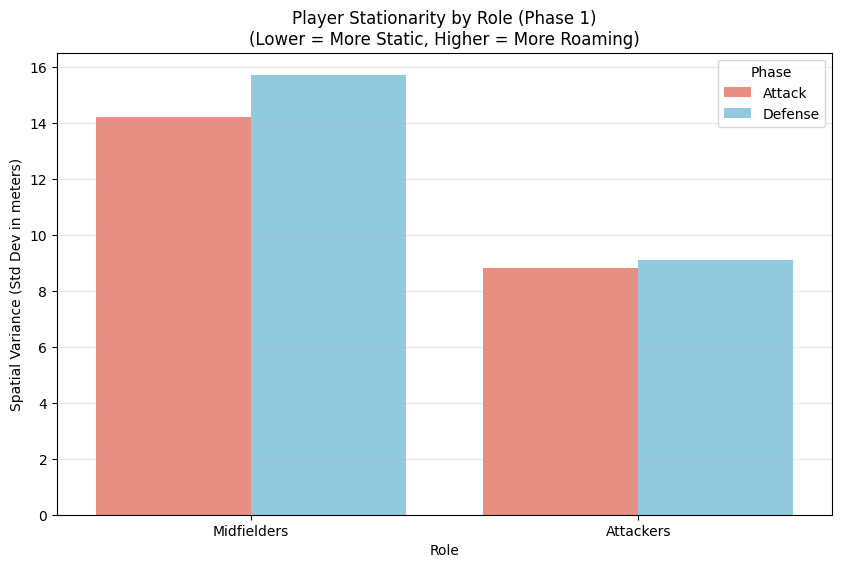

In [21]:
def visualize_role_stationarity(results, phase_idx=0):
    data = results[phase_idx]
    avg_pos = data['means_att']
    att_std = data['attack_std']
    def_std = data['defense_std']
    
    # --- 1. Automatic Role Assignment (based on Avg X Position) ---
    # Assuming Pitch is Centered at (0,0) with X range approx [-52, 52]
    # Adjust thresholds if your coordinates are 0-105
    role_groups = {'Defenders': [], 'Midfielders': [], 'Attackers': []}
    
    for pid, (x, y) in enumerate(avg_pos):
        if x < -15:
            role_groups['Defenders'].append(pid)
        elif x > 15:
            role_groups['Attackers'].append(pid)
        else:
            role_groups['Midfielders'].append(pid)
            
    # --- 2. Calculate Aggregated Metrics ---
    metrics = {
        'Role': [], 'Phase': [], 'Stationarity (m)': []
    }
    
    print(f"\n--- Stationarity Metrics (Phase {phase_idx+1}) ---")
    print(f"{'Role':<15} | {'Att Stationarity':<18} | {'Def Stationarity':<18} | {'Diff (Att-Def)':<15}")
    print("-" * 70)
    
    for role, pids in role_groups.items():
        if not pids: continue
        
        # Average the std dev of all players in this role
        avg_stat_att = np.mean(att_std[pids])
        avg_stat_def = np.mean(def_std[pids])
        diff = avg_stat_att - avg_stat_def
        
        print(f"{role:<15} | {avg_stat_att:.2f} m             | {avg_stat_def:.2f} m             | {diff:+.2f} m")
        
        # Prepare for plotting
        metrics['Role'].append(role)
        metrics['Phase'].append('Attack')
        metrics['Stationarity (m)'].append(avg_stat_att)
        
        metrics['Role'].append(role)
        metrics['Phase'].append('Defense')
        metrics['Stationarity (m)'].append(avg_stat_def)

    # --- 3. Plot Comparison ---
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    df_metrics = pd.DataFrame(metrics)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_metrics, x='Role', y='Stationarity (m)', hue='Phase', palette=['salmon', 'skyblue'])
    plt.title(f"Player Stationarity by Role (Phase {phase_idx+1})\n(Lower = More Static, Higher = More Roaming)")
    plt.ylabel("Spatial Variance (Std Dev in meters)")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# --- Execution ---
# 1. Run Calculations
stat_results = calculate_stationarity_and_roles(X_full, det_segments_full, idx_attack, idx_defense)

# 2. Visualize
if stat_results:
    visualize_role_stationarity(stat_results, phase_idx=0)

In [22]:
from statsbombpy import sb

# --- 1. Fetch a Barcelona Match ---
print("Fetching Competitions...")
comps = sb.competitions()
# Filter for La Liga (Spain)
la_liga = comps[(comps['country_name'] == 'Spain') & (comps['competition_name'] == 'La Liga')]

if la_liga.empty:
    raise ValueError("No La Liga data found in StatsBomb free data.")

# Pick the most recent available season
season = la_liga.sort_values('season_name', ascending=False).iloc[0]
print(f"Selected Season: {season['season_name']}")

# Get Matches
matches = sb.matches(competition_id=season['competition_id'], season_id=season['season_id'])
barca_matches = matches[(matches['home_team'] == 'Barcelona') | (matches['away_team'] == 'Barcelona')]

if barca_matches.empty:
    raise ValueError("No Barcelona matches found in this season.")

# Pick the first match (e.g., vs Real Betis, etc.)
target_match = barca_matches.iloc[0]
match_id = target_match['match_id']
print(f"Selected Match: Barcelona vs {target_match['away_team'] if target_match['home_team']=='Barcelona' else target_match['home_team']} (ID: {match_id})")

# Load Events
events = sb.events(match_id=match_id)
print(f"Loaded {len(events)} events.")

# --- 2. Preprocessing & Imputation (The Critical Step) ---
# --- 2. Preprocessing & Imputation (Corrected) ---

# A. Standardize Coordinates to Barcelona Perspective
def standardize_coords(row):
    if not isinstance(row['location'], (list, tuple, np.ndarray)):
        return np.nan, np.nan
    x, y = row['location']
    if row['possession_team'] == 'Barcelona':
        return x, y
    else:
        return 120.0 - x, 80.0 - y

# Apply transformation
events['std_x'], events['std_y'] = zip(*events.apply(standardize_coords, axis=1))

# B. Create Time Grid
events['timestamp_dt'] = pd.to_datetime(events['timestamp'], format='%H:%M:%S.%f')
# Calculate seconds from match start
events['seconds'] = (events['timestamp_dt'] - events['timestamp_dt'].min()).dt.total_seconds().astype(int)

max_time = events['seconds'].max()
time_grid = np.arange(0, max_time + 1)

# Identify Top 11 Players
player_event_counts = events[events['team'] == 'Barcelona']['player'].value_counts()
top_11_players = player_event_counts.head(11).index.tolist()
print(f"Selected Top 11 Players: {top_11_players}")

# C. Build Tensor X (Time x Players x 2)
X_barca = np.full((len(time_grid), len(top_11_players), 2), np.nan)

for i, player_name in enumerate(top_11_players):
    # --- FIX START ---
    # Filter events for this player
    p_df = events[events['player'] == player_name]
    
    # Group by 'seconds' and take the MEAN position to handle duplicate times
    # This ensures the index is unique
    p_events_unique = p_df.groupby('seconds')[['std_x', 'std_y']].mean()
    
    # Reindex to the full time grid (0 to end of match)
    p_trace = p_events_unique.reindex(time_grid)
    # --- FIX END ---
    
    # Forward Fill: Assume player stays in place until their next action
    p_trace = p_trace.ffill(limit=60) 
    
    # Fill remaining NaNs (e.g., start of match before first touch) with first valid position
    p_trace = p_trace.bfill()
    
    # Final check for any stubborn NaNs (fill with 0 or center)
    p_trace = p_trace.fillna(0)
    
    X_barca[:, i, :] = p_trace.values

print(f"Constructed Imputed Trajectory Tensor: {X_barca.shape}")


Fetching Competitions...
Selected Season: 2020/2021
Selected Match: Barcelona vs Deportivo Alavés (ID: 3773386)
Loaded 3891 events.
Selected Top 11 Players: ['Frenkie de Jong', 'Gerard Piqué Bernabéu', 'Sergi Roberto Carnicer', 'Lionel Andrés Messi Cuccittini', 'Miralem Pjanić', 'Clément Lenglet', 'Anssumane Fati', 'Pedro González López', 'Jordi Alba Ramos', 'Sergio Busquets i Burgos', 'Francisco António Machado Mota de Castro Trincão']
Constructed Imputed Trajectory Tensor: (2998, 11, 2)


In [23]:
# A. Role Alignment (EM-Hungarian)
# We must align the tensor so that index '0' is always the same tactical role (e.g. Left Back)
# even if players swap positions. This is crucial for accurate formation detection.
print("1. Aligning Player Roles...")
mu_barca, roles_barca = FormCPD.em_hungarian(X_barca, n_iter=10)

# Create the aligned tensor (X_barca_metric) expected by the plotter
X_barca_metric = np.zeros_like(X_barca)
for t in range(len(X_barca)):
    X_barca_metric[t] = X_barca[t, roles_barca[t]]

# B. Build Adjacency Matrices
# Since StatsBomb data is approx 1Hz (1 frame/sec), we can compute this for every frame
# or subsample slightly (e.g., every 5 seconds) for speed. Let's do every frame for accuracy.
print("2. Computing Formation Graphs...")
A_barca_seq = []
valid_frames = np.arange(len(X_barca_metric))

for t in valid_frames:
    try:
        # Calculate Delaunay adjacency for the 11 players at time t
        adj = FormCPD.delaunay_adjacency(X_barca_metric[t])
        A_barca_seq.append(adj)
    except:
        # Fallback for empty/error frames
        A_barca_seq.append(np.zeros((11, 11)))

A_barca_seq = np.array(A_barca_seq)

# C. Detect Formation Changes
print("3. Detecting Formation Changes...")
# Run the detection algorithm
results_barca = FormCPD.detect_formation_changes(
    A_barca_seq,
    fps=1,            # Data is 1 frame per second
    alpha=0.05,       # Significance level
    min_minutes=5,    # Minimum phase duration (e.g., 5 mins)
    min_dist=5        # Minimum separation
)

print(f"Success! Detected {results_barca['num_phases']} phases.")
print(f"Segments: {results_barca['segments']}")

1. Aligning Player Roles...


EM-Hungarian: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


2. Computing Formation Graphs...
3. Detecting Formation Changes...
Original edge-count statistic (a): p-value approximation without skewness correction is reported.
Original edge-count statistic (u): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (a): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (u): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (a): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (u): p-value approximation without skewness correction is reported.
Original edge-count scan statistic (a) : 
  Estimated change-point location: 1764 
  Test statistic: 77.13072 
  Approximated p-value: 0 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 1372 
  Test statistic: 112.45 
  Approximated p-value: 0 
Weighted edge-count statistic (a) : 
  Estimated change-point location:

Detected 1 Tactical Phases.


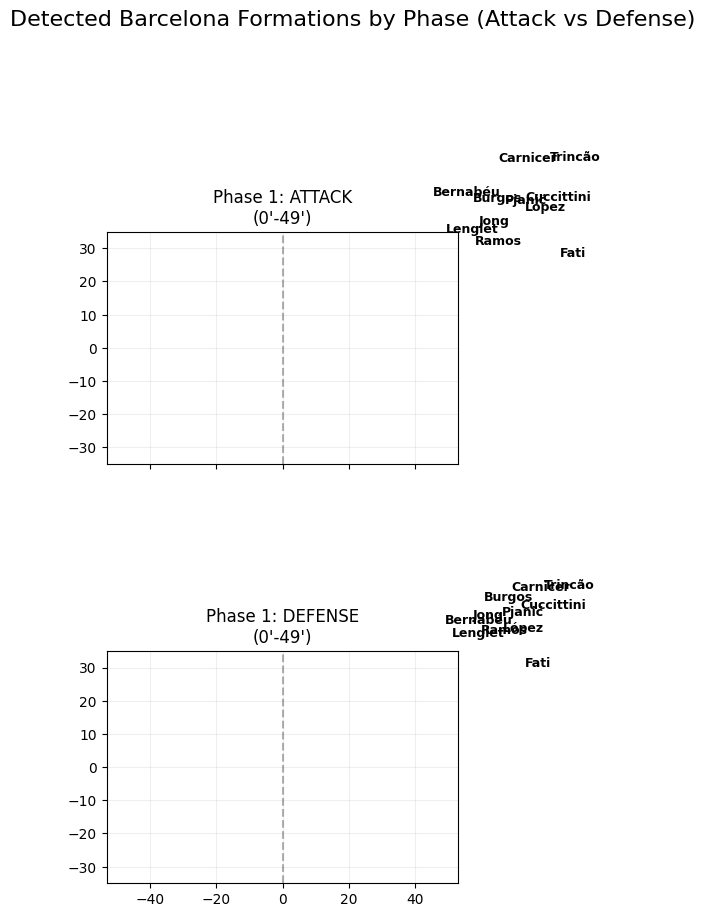

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1. Define Possession Context (Attack vs Defense) ---
# Ensure 'events' DataFrame is available
if 'possession_team' in events.columns:
    # FIX: Use .groupby('seconds').last() instead of .set_index() 
    # This aggregates duplicate seconds into a single unique entry per second.
    possession_map = events.groupby('seconds')['possession_team'].last().reindex(time_grid).ffill()
    
    # Define Indices
    # Attack: When Barcelona has the ball
    idx_att_barca = np.where(possession_map == 'Barcelona')[0]
    # Defense: When Barcelona does NOT have the ball (Opponent or None)
    idx_def_barca = np.where(possession_map != 'Barcelona')[0]
else:
    print("Warning: 'possession_team' column not found. Creating dummy indices.")
    idx_att_barca = np.arange(len(time_grid))
    idx_def_barca = np.array([])

# --- 2. Iterate Detected Phases & Compute Formations ---
segments = results_barca['segments']
n_phases = len(segments)

print(f"Detected {n_phases} Tactical Phases.")

# Setup Plot: Top row = Attack, Bottom row = Defense
fig, axes = plt.subplots(2, n_phases, figsize=(6 * n_phases, 10), sharex=True, sharey=True)

# Handle single phase case (ensure axes is always 2D array)
if n_phases == 1:
    axes = axes[:, np.newaxis]

for i, (start, end) in enumerate(segments):
    # Indices for this specific segment
    phase_frames = np.arange(start, end)
    
    # Intersection: Segment Frames AND Attack/Defense State
    curr_att_idx = np.intersect1d(phase_frames, idx_att_barca)
    curr_def_idx = np.intersect1d(phase_frames, idx_def_barca)
    
    # --- A. Plot Attacking Formation (Top Row) ---
    ax_att = axes[0, i]
    if len(curr_att_idx) > 10: # Minimum data threshold
        # Filter Tensor: (Frames, Players, 2)
        pos_att = X_barca_metric[curr_att_idx] 
        # Calculate Mean Position (Centroid) -> The "Formation"
        mu_att = np.nanmean(pos_att, axis=0)
        
        # Scatter Plot
        ax_att.scatter(mu_att[:, 0], mu_att[:, 1], c='red', s=150, edgecolors='k', zorder=5)
        
        # Annotate Players
        for p_idx, (px, py) in enumerate(mu_att):
            if not np.isnan(px):
                # Use last name for brevity
                name = top_11_players[p_idx].split()[-1] 
                ax_att.text(px, py+3, name, ha='center', fontsize=9, fontweight='bold')
        
        ax_att.set_title(f"Phase {i+1}: ATTACK\n({start//60}'-{end//60}')")
    else:
        ax_att.text(0, 0, "Low/No Possession Data", ha='center')
        ax_att.set_title(f"Phase {i+1}: ATTACK")

    # --- B. Plot Defensive Formation (Bottom Row) ---
    ax_def = axes[1, i]
    if len(curr_def_idx) > 10:
        pos_def = X_barca_metric[curr_def_idx]
        mu_def = np.nanmean(pos_def, axis=0)
        
        ax_def.scatter(mu_def[:, 0], mu_def[:, 1], c='blue', s=150, edgecolors='k', zorder=5)
        
        for p_idx, (px, py) in enumerate(mu_def):
            if not np.isnan(px):
                name = top_11_players[p_idx].split()[-1]
                ax_def.text(px, py+3, name, ha='center', fontsize=9, fontweight='bold')
                
        ax_def.set_title(f"Phase {i+1}: DEFENSE\n({start//60}'-{end//60}')")
    else:
        ax_def.text(0, 0, "Low/No Defense Data", ha='center')
        ax_def.set_title(f"Phase {i+1}: DEFENSE")

    # --- C. Pitch Formatting ---
    for ax in [ax_att, ax_def]:
        # Pitch Dimensions (105x68 approx)
        ax.set_xlim(-53, 53)
        ax.set_ylim(-35, 35)
        ax.axvline(0, c='k', alpha=0.3, linestyle='--') # Center line
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)

plt.suptitle("Detected Barcelona Formations by Phase (Attack vs Defense)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Recalculating Metrics...
Visualizing...

--- Stationarity Metrics (Phase 1) ---
Role            | Att Stationarity   | Def Stationarity   | Diff           
----------------------------------------------------------------------
Midfielders     | 16.14 m             | 14.95 m             | +1.19 m
Attackers       | 15.02 m             | 14.14 m             | +0.88 m


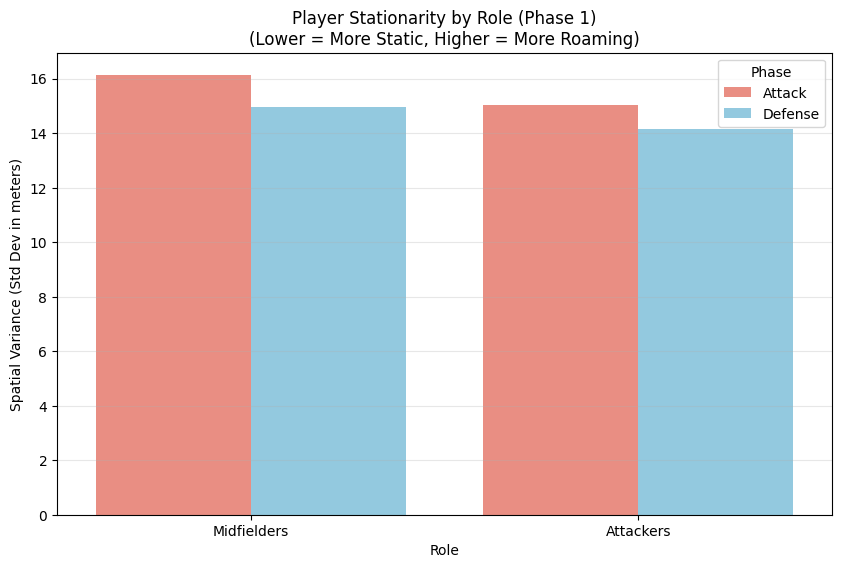

In [25]:
# --- 1. Redefine Calculation Function (Ensuring 'means_att' is saved) ---
def calculate_stationarity_metrics(X_tensor, segments, attack_indices, defense_indices):
    results = []

    for phase_id, (start, end) in enumerate(segments):
        phase_frames = np.arange(start, end)
        phase_att_idx = np.intersect1d(phase_frames, attack_indices)
        phase_def_idx = np.intersect1d(phase_frames, defense_indices)
        
        # --- Attack Metrics ---
        if len(phase_att_idx) > 10:
            pos_att = X_tensor[phase_att_idx] 
            means_att = np.nanmean(pos_att, axis=0) # <--- CRITICAL: Calculate Mean Positions
            dists_att = np.linalg.norm(pos_att - means_att, axis=2)
            std_att = np.nanstd(dists_att, axis=0)
        else:
            means_att = np.zeros((X_tensor.shape[1], 2))
            std_att = np.zeros(X_tensor.shape[1])

        # --- Defense Metrics ---
        if len(phase_def_idx) > 10:
            pos_def = X_tensor[phase_def_idx]
            means_def = np.nanmean(pos_def, axis=0)
            dists_def = np.linalg.norm(pos_def - means_def, axis=2)
            std_def = np.nanstd(dists_def, axis=0)
        else:
            std_def = np.zeros(X_tensor.shape[1])
            
        results.append({
            'phase': phase_id,
            'means_att': means_att, # <--- CRITICAL: Save Mean Positions
            'attack_std': std_att,
            'defense_std': std_def
        })
        
    return results

# --- 2. Redefine Visualization Function ---
def visualize_role_stationarity(results, phase_idx=0):
    if not results:
        print("No results to visualize.")
        return

    data = results[phase_idx]
    
    # Safety Check
    if 'means_att' not in data:
        print("Error: 'means_att' missing. Please re-run the calculation function.")
        return

    avg_pos = data['means_att']
    att_std = data['attack_std']
    def_std = data['defense_std']
    
    # Auto-assign Roles based on X position (Assuming 105x68 pitch)
    # Defenders < 35m, Midfielders 35-70m, Attackers > 70m
    role_groups = {'Defenders': [], 'Midfielders': [], 'Attackers': []}
    
    for pid, (x, y) in enumerate(avg_pos):
        if x < 35: # Defensive Third
            role_groups['Defenders'].append(pid)
        elif x > 70: # Final Third
            role_groups['Attackers'].append(pid)
        else:
            role_groups['Midfielders'].append(pid)
            
    # Calculate & Print Metrics
    metrics = {'Role': [], 'Phase': [], 'Stationarity (m)': []}
    
    print(f"\n--- Stationarity Metrics (Phase {phase_idx+1}) ---")
    print(f"{'Role':<15} | {'Att Stationarity':<18} | {'Def Stationarity':<18} | {'Diff':<15}")
    print("-" * 70)
    
    for role, pids in role_groups.items():
        if not pids: continue
        
        avg_stat_att = np.mean(att_std[pids])
        avg_stat_def = np.mean(def_std[pids])
        diff = avg_stat_att - avg_stat_def
        
        print(f"{role:<15} | {avg_stat_att:.2f} m             | {avg_stat_def:.2f} m             | {diff:+.2f} m")
        
        metrics['Role'].append(role)
        metrics['Phase'].append('Attack')
        metrics['Stationarity (m)'].append(avg_stat_att)
        
        metrics['Role'].append(role)
        metrics['Phase'].append('Defense')
        metrics['Stationarity (m)'].append(avg_stat_def)

    # Plot
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    df_metrics = pd.DataFrame(metrics)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_metrics, x='Role', y='Stationarity (m)', hue='Phase', palette=['salmon', 'skyblue'])
    plt.title(f"Player Stationarity by Role (Phase {phase_idx+1})\n(Lower = More Static, Higher = More Roaming)")
    plt.ylabel("Spatial Variance (Std Dev in meters)")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# --- 3. Execute Sequence ---
print("Recalculating Metrics...")
stat_metrics_barca = calculate_stationarity_metrics(
    X_barca_metric, 
    results_barca['segments'], 
    idx_att_barca, 
    idx_def_barca
)

print("Visualizing...")
visualize_role_stationarity(stat_metrics_barca, phase_idx=0)